# Second First Assignment - Netflix Stock

## Data Manipulation

In this second assignment we are going to apply three models - ARMA, GARCH and Markov Chain (MC) - in the Netflix Inc return series, from 12/31/2014 to 12/31/2020. We are using python3.x in a Jupyter Notebook, in the end the *.py* code will be provided. The data was collected from Yahoo Finance, in this [link](https://finance.yahoo.com/quote/NFLX/history?period1=1420070400&period2=1609459200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).


Like any program in python we start by installing and importing the necessary packages.

In [ ]:
###You must have this two libs installed.
##You can install removing the comemments of the lines below

#!pip install arch
#!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import datetime as datetime
import matplotlib.dates as mdates
import seaborn; seaborn.set()
from arch import arch_model
import statsmodels as sm

%matplotlib inline 

Then, reading the csv and showing the first line to be sure everything is in order.

In [ ]:
df = pd.read_csv('NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000
1,2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000
2,2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700
3,2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700
4,2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900


Let's see the type of the data's columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1511 non-null   object 
 1   Open       1511 non-null   float64
 2   High       1511 non-null   float64
 3   Low        1511 non-null   float64
 4   Close      1511 non-null   float64
 5   Adj Close  1511 non-null   float64
 6   Volume     1511 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.8+ KB


The date column is stored as an object, which is not the type we need it. We will use this function and pandas will take care of it.




In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

Just to be sure, repeating the function

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1511 non-null   datetime64[ns]
 1   Open       1511 non-null   float64       
 2   High       1511 non-null   float64       
 3   Low        1511 non-null   float64       
 4   Close      1511 non-null   float64       
 5   Adj Close  1511 non-null   float64       
 6   Volume     1511 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.8 KB


Now we got the Dateframe in datetime type of memory, we can apply our models

## Returns

The linear return represents how much the price variates from time to time. Using the equation

\begin{align}
  R_{t} = \frac{x_{i+\Delta t}}{x_i} - 1
\end{align}

denoting $x_{i}$ as the price of the day and $\Delta t$ as time variation. Here $\Delta t$ equals one day and then we will have the linear return ($R_t$) for every day of our series, except from the last day, as we necessarialy will need the price of next day.Defining

\begin{align}
  r_{t} = \log{(1 + R_t)}
\end{align}

and inputing the equation of linear return we obtain the log return

\begin{align}
  r_{t} = \log{\left(\frac{x_{i+\Delta t}}{x_{i}}\right)} =\log{(x_{i+\Delta t})} - \log{(x_i)} \approx R_t
\end{align}

It is an approximation of the linear return, but have some better statistics proprieties [[$^1$](http://www.portalaction.com.br/series-temporais/51-retornos)]. Again, we use $\Delta t$ as one day and this gives us the log return ($r_{t}$) for every day of our series.

The normalized return is modeled by

\begin{align}
  r_{a} = \frac{(r_t - \mu)}{\sigma}
\end{align}

where $\mu$ is the mean of our series and $\sigma$ is de standard deviation. The reason to do this return is to compare with others, but this is not the scope of this work. We're just introducing some important returns. 

In [ ]:
##preps
N = len(df['Date'])

c_values = df['Close'].values
d_valuess = df['Date'].values
d_values = []
l_return = []
log_return = []
n_return = []

##linear return
for i in range(N-1):
  l_return.append(c_values[i + 1]/c_values[i] - 1)
  d_values.append(d_valuess[i])

##log return
for i in range(N-1):
  log_return.append(np.log(c_values[i+1]) - np.log(c_values[i]))

##normalized return
mean = np.average(log_return)
stdev = np.std(log_return)

for i in range(N-1):
  n_return.append((log_return[i]-mean)/stdev)

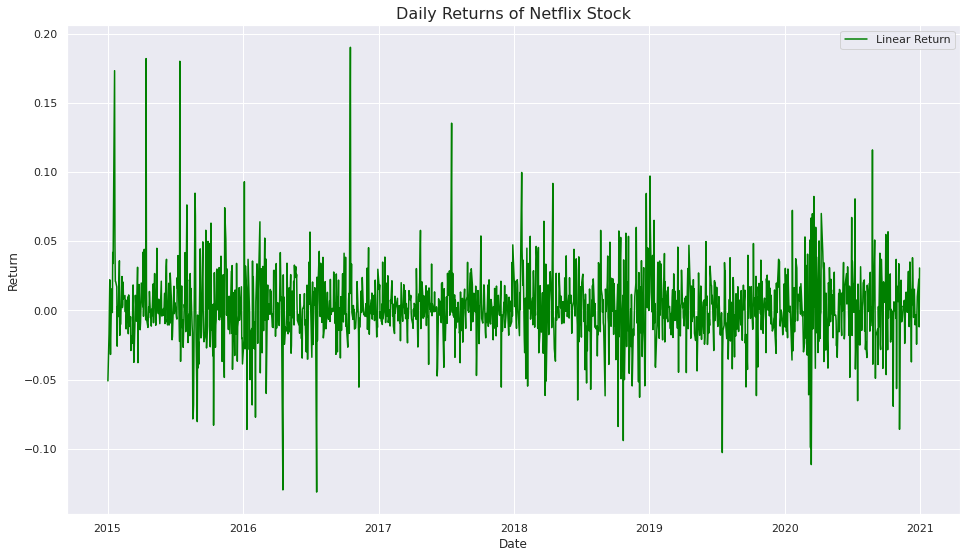

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(d_values, l_return, c='green', label='Linear Return')

plt.legend(loc='upper right')
plt.title('Daily Returns of Netflix Stock', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return')

plt.show()

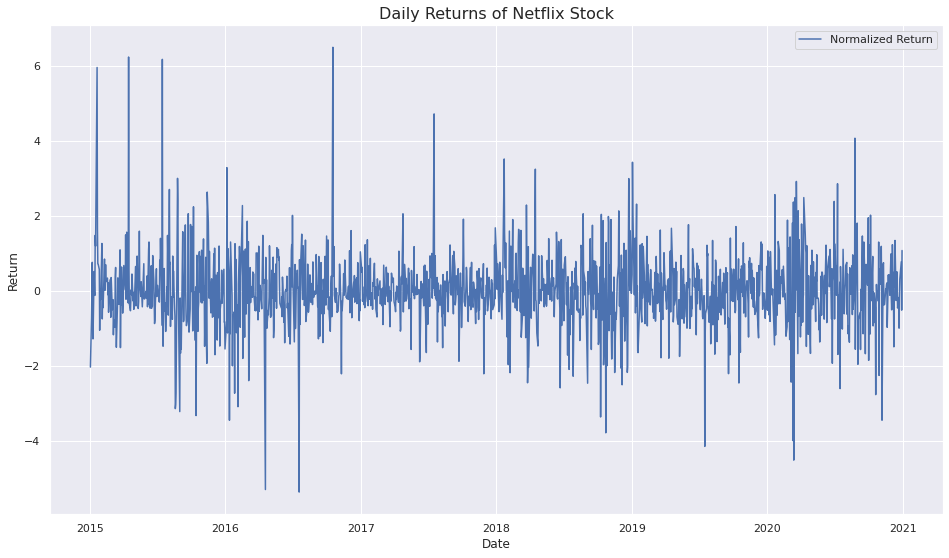

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(d_values, n_return, label='Normalized Return')

plt.legend(loc='upper right')
plt.title('Daily Returns of Netflix Stock', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return')

plt.show()

With our returns we can make our desired models

## ARMA Model


The ARMA model is defined by

\begin{aligned}
        y(t) = \sum_{n=1}^P(\phi(n) y(t-n)  + \epsilon(n))  +
        \sum_{m=1}^Q \theta(m) \epsilon(t-m) 
\end{aligned}

The sum of $n$ and $m$ is from zero to an order $P$ and $Q$, respectively, which gives the order of the model. $\phi(n)$ and $\theta(m)$ are constants. $\epsilon(n)$ are the inovation.

To find the constants $\phi(n)$ (PACF) we are use the Yule Walker method. The Yule Walker uses the autocorrelation, as defined by

\begin{aligned}
    \left[\begin{array}{c}
        \phi_1 \\ 
        \phi_2 \\
        \vdots \\
        \phi_P
    \end{array}\right] =
        \left[\begin{array}{cccc}
        1 & r_{xx}(1) & \ldots & r_{xx}(P-1) \\
        r_{xx}(-1) & 1 & \ldots &r_{xx}(P-2) \\
        \vdots & \vdots & \ddots & \vdots \\
        r_{xx}(P-1) & \ldots &r_{xx}(1) & 1
    \end{array}\right]
    \left[\begin{array}{c}
        r_{xx}(1) \\ 
        r_{xx}(2) \\
        \vdots \\
        r_{xx}(P)
    \end{array}\right]
\end{aligned}

for any order of $P$, here is used 100, where $r_{xx}$ is the return's autocorrelation. With the constants $\phi$ we obtain the AR model, we still need the $\theta(m)$ values, which is given by

\begin{aligned}
    \theta = \left(\frac{\sigma^2(y(t))}{\sigma^2(\epsilon(t))} -1 \right)^{1/2}
\end{aligned}

for $Q = 1$. 

Making the Autocorrelation Function

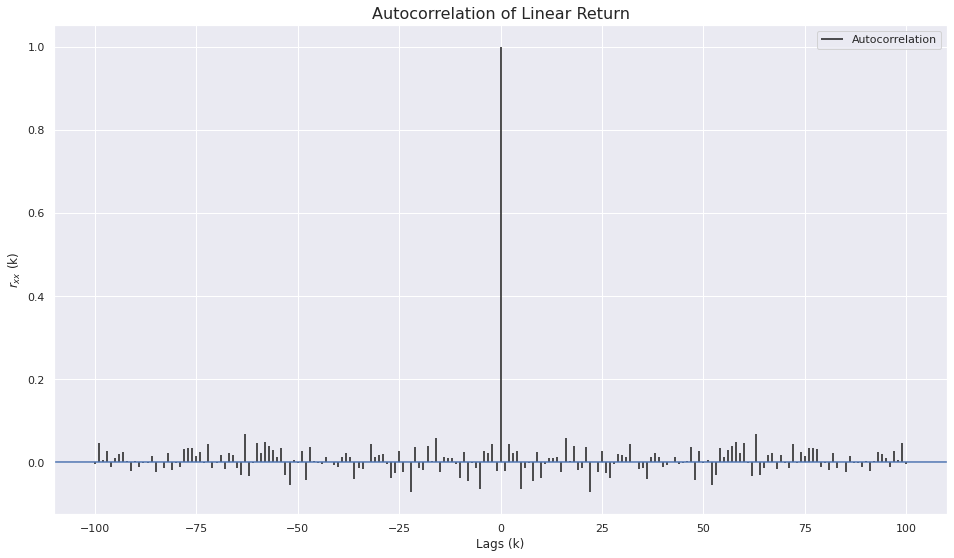

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
lags = 100

ACF = plt.acorr(l_return, maxlags=lags, label="Autocorrelation") 

plt.title('Autocorrelation of Linear Return', fontsize=16)
plt.xlabel('Lags (k)')
plt.ylabel('$r_{xx}$ (k)')
plt.legend(loc="best")

plt.show()

Calculating the PACF

In [ ]:
R = []
phi = []
zero = int((len(ACF[1])-1)/2)
line = 0

while (line<zero):
    row = []
    for j in range(zero):
      row.append(ACF[1][zero + j - line])
    R.append(row)
    line = line + 1

rxx = ACF[1][(zero+1):(zero+1+lags)]
R_inverse = np.linalg.inv(np.array(R)) 

phi = np.matmul(R_inverse, rxx)
phi = np.insert(phi, 0, 1)

Plotting

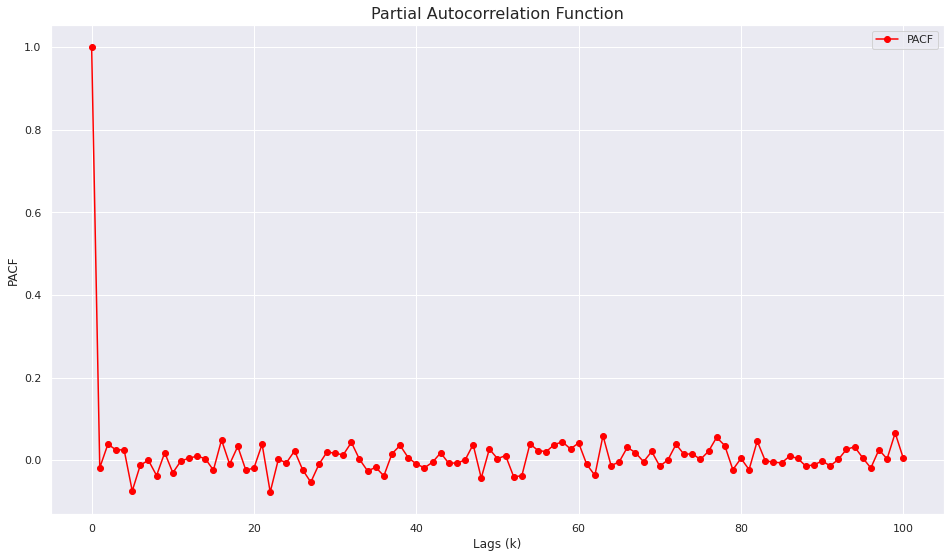

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(phi, label="PACF", marker='o', color='red')
plt.title('Partial Autocorrelation Function', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Lags (k)')
plt.ylabel('PACF')

plt.show()

Obtaining the AR model

In [ ]:
mu = 0 
sigma = 0.1
epsilon = np.random.normal(mu, sigma, N)

y_ar = []

for i in range(N-1):
  sum = 0
  n = 1
  for n in range(1, len(phi)-1):
    sum = phi[n]*n_return[i-n] + epsilon[n] + sum
  y_ar.append(sum)

Plotting

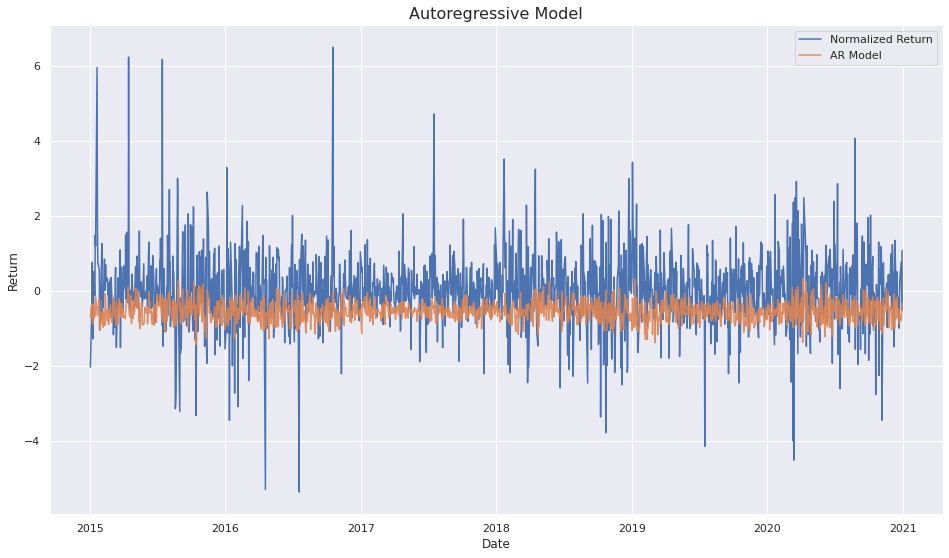

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(d_values, n_return, label="Normalized Return")
plt.plot(d_values, y_ar, label="AR Model", alpha=0.9)

plt.title('Autoregressive Model', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return')

plt.show()

Let's calculate the MA model and join with the AR.

In [ ]:
var_xt  = np.var(n_return)
var_e = np.var(epsilon)

theta = ((var_xt/var_e) - 1 )**(1/2)
arma = []

for j in range(len(y_ar)):
  arma.append(y_ar[j] + theta*epsilon[j])

Plotting

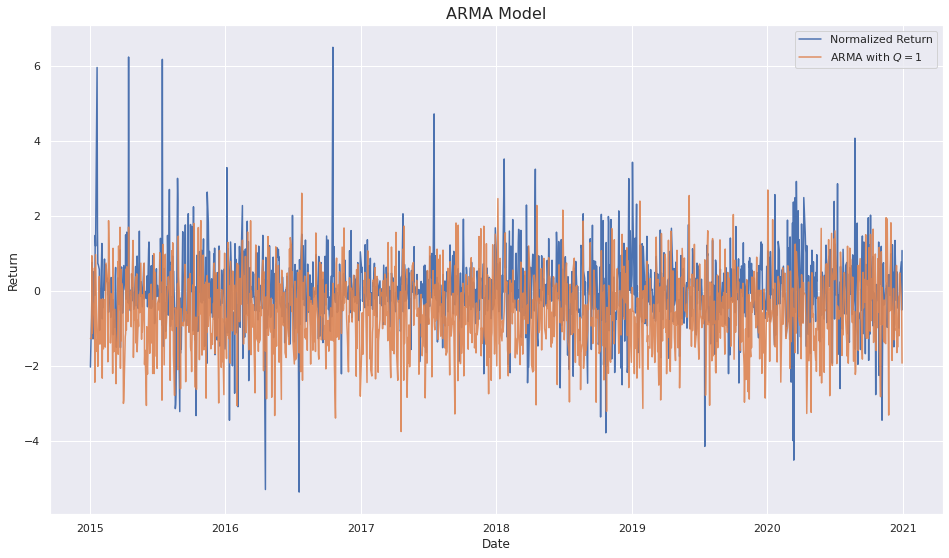

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(d_values, n_return, label="Normalized Return")
plt.plot(d_values, arma, label="ARMA with $Q = 1$", alpha=.9)

plt.title('ARMA Model', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return')

plt.show()

Taking sum of our residues

In [ ]:
r_total = 0
residue = []

for i in range(len(arma)):
  r = (n_return[i] - arma[i])**2
  r_total = r + r_total
  residue.append(r)

print(np.sqrt(r_total))

57.953549120240844


Plotting

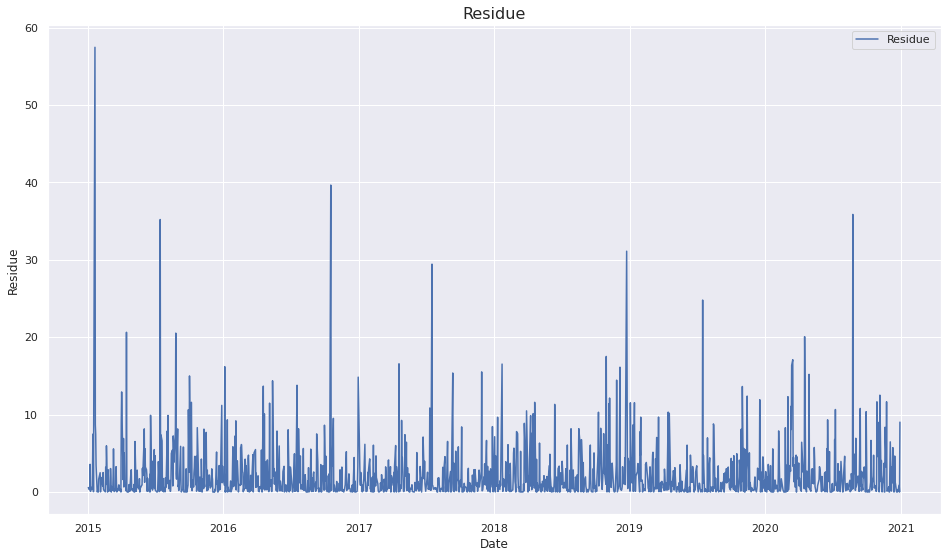

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(d_values, residue, label="Residue")

plt.title('Residue', fontsize=16)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Residue')

plt.show()

## GARCH Model

The GARCH model is defined by

\begin{aligned}
    \sigma(t)^2 = \omega + \alpha r(t-1)^2 + \beta \sigma(t-1)^2
\end{aligned}

Where $\sigma^2$  is the conditional volatility and $r$ is our return. $\omega$, $\alpha$ and $\beta$ are constants to be found. Fitting the function we find

In [ ]:
garch_model = arch_model(log_return, vol='Garch', p=1, q=1, dist='Normal')
model_fit = garch_model.fit()
estimation = model_fit.forecast()

print(model_fit)

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3367.9115372716815
Iteration:      2,   Func. Count:     19,   Neg. LLF: -3367.9218333299814
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3367.92183423405
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3367.92
Distribution:                  Normal   AIC:                          -6727.84
Method:            Maximum Likelihood   BIC:                          -6706.56
                                        No. Observations:                 1510
Date:                Wed, Mar 24 2021   Df Residuals:                     1509
Time:       

Using the function we can that our constants are

In [ ]:
omega = 7.0346e-05
alpha = 0.05
beta  = 0.85

Inserting ou constants we can make the plot of the GARCH Model for our log return.

In [ ]:
sig_garch = []

for i in range(len(n_return)):
  sig_garch.append(omega + alpha*(l_return[i-1]**2) + beta*(varGARCH[i-1]**2))

Plotting

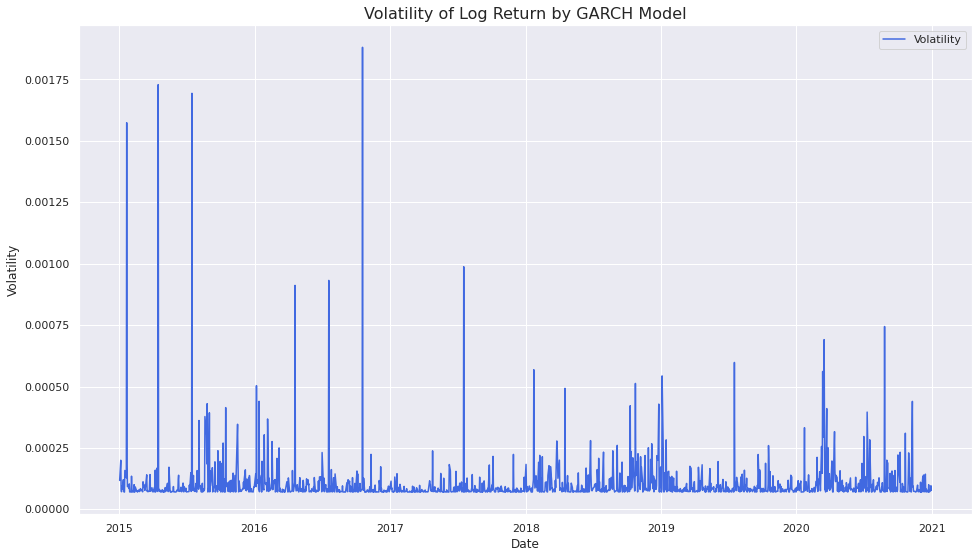

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

plt.plot(d_values, sig_garch, color="royalblue", label="Volatility")

plt.title('Volatility of Log Return by GARCH Model',fontsize=16)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend()

plt.show()

We can cleary see some volatility clusters where the spike of the graph is too big. 

## Markov Chain

Making a Markov Chain evolution of our Normalized Return

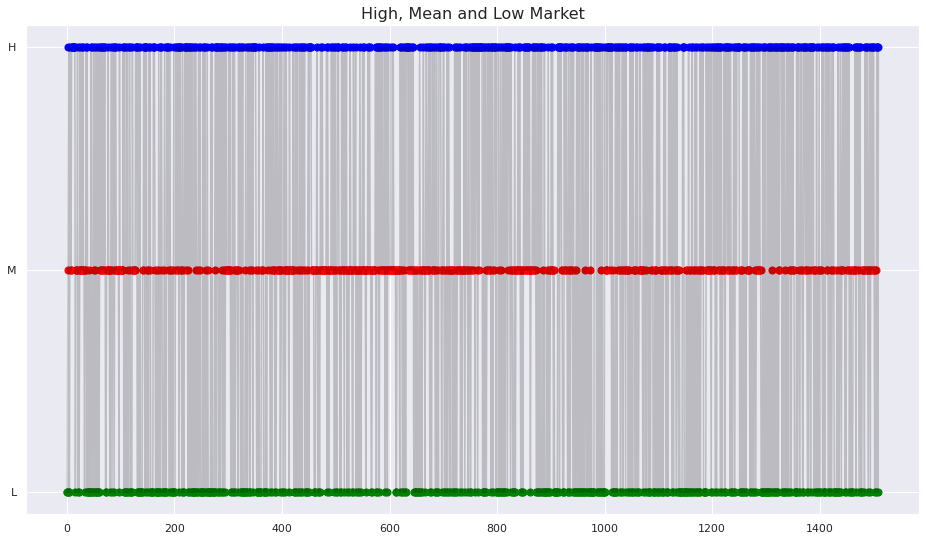

In [ ]:
mc = pd.DataFrame()
mc['labels'] = pd.qcut(n_return, 3, labels=["L", "M", "H"])
mc = mc.sort_index()

col = []

for i in range(0, len(markov_df)): 
    if markov_df['labels'][i]=='L':
        col.append('green')   
    if markov_df['labels'][i]=='M': 
        col.append('red') 
    if markov_df['labels'][i]=='H':
        col.append('blue')  

fig, ax = plt.subplots(figsize=(16, 9))
plt.title('High, Mean and Low Market', fontsize=16)

for i in range(len(markov_df)):
    plt.scatter(x=markov_df.index[i], y=markov_df['labels'][i], s=50, c=col[i])

plt.plot(markov_df['labels'], color="black", alpha=0.2)
plt.yticks()

plt.show()

In matrix notation

In [ ]:
def build_transition_grid(labelSeries, label):
    list_seq = []
    for i in range(len(labelSeries)-1):
            list_seq.append(labelSeries[i] + '-' + labelSeries[i+1])
    
    nlabels = pd.Series(data=list_seq)
    uniqueValues = nlabels.unique()
    count = nlabels.value_counts(normalize=True)
    print(count)

build_transition_grid(markov_df['labels'], ['L', 'H', 'M'])

L-H    0.123260
H-L    0.123260
M-M    0.122598
M-H    0.118622
L-L    0.117959
H-M    0.117959
L-M    0.092777
M-L    0.092114
H-H    0.091451
dtype: float64


Making the Transition Matrix we obtain

\begin{aligned}
    T(m,n) = 
    \left[ \begin{array}{ccc}
        0.091 & 0.118 & 0.123 \\
        0.118 & 0.126 & 0.093 \\
        0.123 & 0.092 & 0.118
    \end{array}\right]
\end{aligned}

where the indices are showned in the output of the code above.